# 2. Baseline Metrics

In [1]:
!git clone https://github.com/cmhobbs96/meta-semantic-research.git

fatal: destination path 'meta-semantic-research' already exists and is not an empty directory.


In [2]:
!pip install numpy==1.26.4 pandas==1.5.3 --force-reinstall --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 289.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 254.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 320.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.9/507.9 kB 335.5 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.1
    Uninstalling pytz-2025.1:
      Successfully uninstalled pytz-2025.1
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.17.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.9.0.post0
    Uninstalling python-dateutil-2.9.0.post0:
      

In [2]:
!pip install numpy pandas transformers torch nlkt sympy --upgrade

from google.colab import drive

import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from difflib import unified_diff
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Set device
if torch.cuda.is_available():
  device = torch.device("cuda")
  scaler = GradScaler()
else:
  device = torch.device("cpu")
  scaler = None

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
<ipython-input-2-6805e51a8478>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [3]:
# Define constants
MODEL = "google-t5/t5-small"

NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 3e-5
MAX_LENGTH = 512
ACCUMULATION_STEPS = 2

In [4]:
# Mount to Google Drive
drive.mount('/content/drive')

# Define paths for datasets
train_path = "/content/drive/My Drive/Academia/MS in AI/ECE 57000/Research/data/train.tsv"
test_path = "/content/drive/My Drive/Academia/MS in AI/ECE 57000/Research/data/test.tsv"
gen_path = "/content/drive/My Drive/Academia/MS in AI/ECE 57000/Research/data/gen.tsv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Function to check dataset format
def inspect_dataset(file_path, file_name):
    try:
        data = pd.read_csv(file_path, sep="\t", header=None)  # Load without column names
        print(f"\n Inspecting {file_name}:")
        print(data.head(5))  # Print first 5 rows
        print(f"Columns: {data.columns}")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

# Inspect each dataset
inspect_dataset(train_path, "train.tsv")
inspect_dataset(test_path, "test.tsv")
inspect_dataset(gen_path, "gen.tsv")


 Inspecting train.tsv:
                                             0  \
0                 A rose was helped by a dog .   
1                    The sailor dusted a boy .   
2                      Emma rolled a teacher .   
3                     Evelyn rolled the girl .   
4  A cake was forwarded to Levi by Charlotte .   

                                                   1                2  
0  rose ( x _ 1 ) AND help . theme ( x _ 3 , x _ ...  in_distribution  
1  * sailor ( x _ 1 ) ; dust . agent ( x _ 2 , x ...  in_distribution  
2  roll . agent ( x _ 1 , Emma ) AND roll . theme...  in_distribution  
3  * girl ( x _ 3 ) ; roll . agent ( x _ 1 , Evel...  in_distribution  
4  cake ( x _ 1 ) AND forward . theme ( x _ 3 , x...  in_distribution  
Columns: Index([0, 1, 2], dtype='int64')

 Inspecting test.tsv:
                                                0  \
0  Mila liked that the cake was offered to Emma .   
1   A coach supported that the cake was snapped .   
2                   

**Define Dataset**

In [6]:
class COGSDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Read only the first two columns, skip header
        df = pd.read_csv(file_path, sep="\t", header=None, usecols=[0, 1], skiprows=1, names=["input", "output"])
        df = df.dropna()

        self.inputs = df["input"].tolist()
        self.targets = [o.strip() for o in df["output"].tolist()]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        target_text = self.targets[idx]

        input_enc = self.tokenizer(
            input_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        target_enc = self.tokenizer(
            target_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        labels = target_enc.input_ids.squeeze(0)
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_enc.input_ids.squeeze(0),
            "attention_mask": input_enc.attention_mask.squeeze(0),
            "labels": labels,
            "input_text": input_text,
            "target_text": target_text
        }


In [7]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Create datasets
train_dataset = COGSDataset(train_path, tokenizer)
test_dataset = COGSDataset(test_path, tokenizer)
gen_dataset = COGSDataset(gen_path, tokenizer)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
gen_loader = DataLoader(gen_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define Model (Transformer - T5)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL)

# Define Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [9]:
input_text = "The dog chased the cat."

model.to(device)
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
outputs = model.generate(input_ids).to(device)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Der Hund hat den Hund chased.


In [10]:
# Training function
def train_model(model, train_loader, optimizer, epochs=NUM_EPOCHS):
  model.train()
  loss_fn = nn.CrossEntropyLoss()
  accumulation_steps = ACCUMULATION_STEPS

  for epoch in range(epochs):
    total_loss = 0
    for i, batch in enumerate(train_loader):
      optimizer.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      with autocast("cuda"):
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / accumulation_steps

      scaler.scale(loss).backward()

      if (i + 1) % accumulation_steps == 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

      total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")

In [11]:
# Train model
train_model(model, train_loader, optimizer)

# Save model
model.save_pretrained("models/cogs_t5-small")

print("Training complete. Model saved.")

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/5, Loss: 0.6155641720389688
Epoch 2/5, Loss: 0.16918350942679589
Epoch 3/5, Loss: 0.10896789539136634
Epoch 4/5, Loss: 0.07691363572383558
Epoch 5/5, Loss: 0.0576786757477664
Training complete. Model saved.


In [12]:
# Debug Model
def debug_model(model, test_loader, dataset_name):
  model.eval()
  exact_match = 0
  total = 0
  num_samples_to_check = 10
  checked = 0
  predictions_list = []
  references_list = []

  print(f"Debugging Model...\n")

  with torch.no_grad():
    for batch in test_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      print(f"input_ids.shape: {input_ids.shape}")
      print("Sample input_ids[0]:", input_ids[0])
      print("Decoded input[0]:", tokenizer.decode(input_ids[0], skip_special_tokens=True))

      # Generate predictions
      outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
      )

      decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
      decoded_refs = [
          tokenizer.decode(label[label != -100], skip_special_tokens=True)
          for label in labels
      ]
      raw_preds = [
          tokenizer.decode(output, skip_special_tokens=True)  # Decode labels without padding
          for output in outputs
      ]

      for i in range(len(decoded_preds)):
        print(f"--- Sample {checked + 1} ---")

        print(f"[Input Text]        : {tokenizer.decode(input_ids[i], skip_special_tokens=True)}")
        print(f"[Input Tokens]      : {input_ids[i].tolist()}")
        print(f"[Label Tokens]      : {labels[i].tolist()}")
        print(f"[Generated Tokens]  : {outputs[i].tolist()}")
        print(f"[Reference Text]    : {decoded_refs[i]}")
        print(f"[Decoded Prediction]: {decoded_preds[i]}")
        print(f"[Raw Prediction]    : {raw_preds[i]}")

        # Quick check for empty predictions
        if len(decoded_preds[i].strip()) == 0:
            print("EMPTY PREDICTION")

        # Check if it's an exact match
        if decoded_preds[i].strip() == decoded_refs[i].strip():
            print("Exact Match")
        else:
            print("Mismatch")

        print("\n")
        checked += 1
        if checked >= num_samples_to_check:
            break
      if checked >= num_samples_to_check:
        break

In [19]:
# Evaluate Model
def evaluate_model(model, test_loader, dataset_name):
  start_time = time.time()
  model.eval()
  exact_match = 0
  total = 0
  predictions_list = []
  references_list = []

  sample_precisions = []
  sample_recalls = []
  sample_f1s = []
  sample_bleus = []

  smoothie = SmoothingFunction().method4

  print(f"Evaluating Model...\n")

  with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      # Generate predictions
      outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
      )

      decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
      references = [
          tokenizer.decode(label[label != -100], skip_special_tokens=True)
          for label in labels
      ]
      predictions = [
          tokenizer.decode(output, skip_special_tokens=True)
          for output in outputs
      ]

      # Append to lists
      predictions_list.extend(predictions)
      references_list.extend(references)

      # Calculate exact match
      exact_match += sum([1 for pred, ref in zip(predictions, references) if pred.strip() == ref.strip()])
      total += len(predictions)

      # Token-level precision, recall, f1 per sample
      for pred, ref in zip(predictions, references):
        pred_tokens = pred.split()
        ref_tokens = ref.split()

        # BLEU Score
        if len(pred_tokens) > 0 and len(ref_tokens) > 0:
          bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
          sample_bleus.append(bleu)

        # Token-level metrics
        min_len = min(len(pred_tokens), len(ref_tokens))
        if min_len == 0:
            continue  # skip empty predictions or references
        pred_slice = pred_tokens[:min_len]
        ref_slice = ref_tokens[:min_len]

        sample_precisions.append(precision_score(ref_slice, pred_slice, average='macro', zero_division=0))
        sample_recalls.append(recall_score(ref_slice, pred_slice, average='macro', zero_division=0))
        sample_f1s.append(f1_score(ref_slice, pred_slice, average='macro', zero_division=0))


      if batch_idx == 0:
        print(f"** {dataset_name} Sample Predictions vs. References:**")
        for i in range(min(10, len(predictions))):
          print(f"Batch Index {batch_idx}")
          print(f"---Sample {i+1}---")
          print(f"Prediction: {predictions[i]}")
          print(f"Reference: {references[i]}")
          if predictions[i].strip() != references[i].strip():
            print("Mismatch Detected")
            diff = list(unified_diff([predictions[i]], [references[i]], fromfile='Prediction', tofile='Reference'))
            print("\n".join(diff))
          else:
            print("No Mismatch Detected\n")
          print()

  # Final metrics
  exact_match_score = exact_match / total
  precision = np.mean(sample_precisions)
  recall = np.mean(sample_recalls)
  f1 = np.mean(sample_f1s)
  bleu = np.mean(sample_bleus)
  elapsed_time = time.time() - start_time

  # Print 5 sample predictions for debugging
  print(f"\n** {dataset_name} Sample Predictions vs. References:**")
  for i in range(min(5, len(predictions_list))):
    print(f"{dataset_name} Prediction {i+1}: {predictions_list[i]}")
    print(f"{dataset_name} Reference {i+1}: {references_list[i]}\n")

  print(f"{dataset_name} Exact Match Score: {exact_match_score:.4f}")
  print(f"{dataset_name} Precision: {precision:.4f}")
  print(f"{dataset_name} Recall: {recall:.4f}")
  print(f"{dataset_name} F1 Score: {f1:.4f}")
  print(f"{dataset_name} BLEU Score: {bleu:.4f}")
  print(f"{dataset_name} Elapsed Time: {elapsed_time} seconds")

  return {
      "exact_match": exact_match_score,
      "precision": precision,
      "recall": recall,
      "f1": f1,
      "bleu": bleu,
      "elapsed_time": elapsed_time
  }

In [14]:
batch = next(iter(test_loader))
input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)

outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))



* cake ( x _ 7 ) ; coach ( x _ 1 


In [15]:
# Debug the model on test sets
debug_score = debug_model(model, test_loader, "Test Set")

Debugging Model...

input_ids.shape: torch.Size([32, 128])
Sample input_ids[0]: tensor([   71,  3763,  3510,    24,     8,  4340,    47, 27871,    26,     3,
            5,     1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0

In [20]:
# Evaluate the model on test sets
test_results = evaluate_model(model, test_loader, "Test Set")

Evaluating Model...

** Test Set Sample Predictions vs. References:**
Batch Index 0
---Sample 1---
Prediction: * cake ( x _ 4 ) ; coach ( x _ 1 ) AND support. agent ( x _ 2, x _ 1 ) AND support. ccomp ( x _ 2, x _ 4 ) AND snappe. theme ( x _ 4, x _ 7 )
Reference: * cake ( x _ 5 ) ; coach ( x _ 1 ) AND support. agent ( x _ 2, x _ 1 ) AND support. ccomp ( x _ 2, x _ 7 ) AND snap. theme ( x _ 7, x _ 5 )
Mismatch Detected
--- Prediction

+++ Reference

@@ -1 +1 @@

-* cake ( x _ 4 ) ; coach ( x _ 1 ) AND support. agent ( x _ 2, x _ 1 ) AND support. ccomp ( x _ 2, x _ 4 ) AND snappe. theme ( x _ 4, x _ 7 )
+* cake ( x _ 5 ) ; coach ( x _ 1 ) AND support. agent ( x _ 2, x _ 1 ) AND support. ccomp ( x _ 2, x _ 7 ) AND snap. theme ( x _ 7, x _ 5 )

Batch Index 0
---Sample 2---
Prediction: * moose ( x _ 1 ) ; want. agent ( x _ 2, x _ 1 ) AND want. xcomp ( x _ 2, x _ 4 ) AND read. agent ( x _ 4, x _ 1 )
Reference: * moose ( x _ 1 ) ; want. agent ( x _ 2, x _ 1 ) AND want. xcomp ( x _ 2, x _ 4 ) 

In [21]:
# Evaluate the model on generalization sets
gen_results = evaluate_model(model, gen_loader, "Generalization Set")

Evaluating Model...

** Generalization Set Sample Predictions vs. References:**
Batch Index 0
---Sample 1---
Prediction: think. agent ( x _ 1, Zoe ) AND think. ccomp ( x _ 1, x _ 3 ) AND hippo ( x _ 3 ) AND clean. agent ( x _ 3, x _ 6 )
Reference: think. agent ( x _ 1, Zoe ) AND think. ccomp ( x _ 1, x _ 5 ) AND hippo ( x _ 4 ) AND clean. agent ( x _ 5, x _ 4 )
Mismatch Detected
--- Prediction

+++ Reference

@@ -1 +1 @@

-think. agent ( x _ 1, Zoe ) AND think. ccomp ( x _ 1, x _ 3 ) AND hippo ( x _ 3 ) AND clean. agent ( x _ 3, x _ 6 )
+think. agent ( x _ 1, Zoe ) AND think. ccomp ( x _ 1, x _ 5 ) AND hippo ( x _ 4 ) AND clean. agent ( x _ 5, x _ 4 )

Batch Index 0
---Sample 2---
Prediction: * princess ( x _ 1 ) ; * goose ( x _ 7 ) ; teleport. agent ( x _ 2, x _ 1 ) AND teleport. theme ( x _ 2, x _ 4 ) AND teleport. recipient ( x _ 2, x _ 7 ) AND cookie ( x _ 4 )
Reference: * princess ( x _ 1 ) ; * goose ( x _ 7 ) ; teleport. agent ( x _ 2, x _ 1 ) AND teleport. theme ( x _ 2, x _ 4 )

<Figure size 1000x600 with 0 Axes>

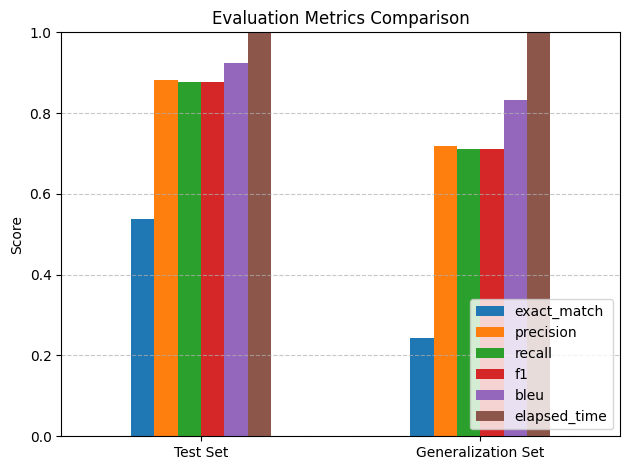

In [22]:
# Display the results using pandas
df = pd.DataFrame([test_results, gen_results], index=["Test Set", "Generalization Set"])
df_display = df.copy()

# Create bar chart
plt.figure(figsize=(10, 6))
df.plot(kind="bar", rot=0)
plt.title("Evaluation Metrics Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()